## Notebook 1 — Data Exploration and Preparation (2015–2025)

This notebook prepares and explores a harmonized hotel-demand panel dataset for EU countries.

---

### **Structure Overview**

0. Environment Setup  
1. Load and Inspect Data  
2. Integrity Checks  
3. Order and Inspect Columns  
4. Imputation and Final Fixes  
5. Exploratory Data Analysis (EDA)  
6. Save Clean Dataset and EDA Summary  
7. Insights and Next Steps

---


### 0. Environmental Setup

In [1]:
# %% ===============================================================
# STEP 0 — ENVIRONMENT SETUP
# Purpose: Import packages, define paths, and configure visualization style.
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import math
import matplotlib.dates as mdates

# Visualization style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

# Directory paths (consistent across all notebooks)
BASE_DIR = Path("..")
DATA_INTERIM = BASE_DIR / "data" / "interim"
DATA_PROCESSED = BASE_DIR / "data" / "processed"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"
MODELS = OUTPUTS / "models"
LOGS = OUTPUTS / "logs"
REPORTS = OUTPUTS / "reports"

# Ensure directories exist
for path in [DATA_INTERIM, DATA_PROCESSED, FIGURES, MODELS, LOGS, REPORTS]:
    path.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")

✅ Environment setup complete.


### 1. Load and Inspect Data

In [2]:
# %% -----------------------------------------------
# STEP 1 — LOAD AND INSPECT PROCESSED HOTEL PANEL DATA
# Purpose: Import harmonized monthly hotel demand data for EU countries (2015–2025)
# Input: data/processed/hotel_panel.csv
# Output: DataFrame df
# -----------------------------------------------

DATA_PATH = DATA_INTERIM / "hotel_panel.csv"

df = pd.read_csv(DATA_PATH, parse_dates=["month"])
df["year"] = df["month"].dt.year

print(f"✅ Dataset loaded successfully: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"📅 Time range: {df['month'].min():%Y-%m} → {df['month'].max():%Y-%m}")
print(f"🌍 Regions: {df['region'].nunique()}")
df.head()

✅ Dataset loaded successfully: 3328 rows × 14 columns
📅 Time range: 2015-01 → 2025-08
🌍 Regions: 26


,region,time_x,nights_spent,gdp,unemployment_rate,turnover_index,hicp_index,month,covid_cases,eurgbp,eurusd,time_y,policy_stringency,year
0,AT,2015-01-31,1833949.0,61688.9,5.5,NaN,98.48,2015-01-31,NaN,0.7488,1.128796,2015-01-31,NaN,2015
1,BE,2015-01-31,388967.0,76937.9,8.4,NaN,97.20,2015-01-31,NaN,0.7488,1.128796,2015-01-31,NaN,2015
2,BG,2015-01-31,337119.0,5283.4,10.7,55.8,99.80,2015-01-31,NaN,0.7488,1.128796,2015-01-31,NaN,2015
3,CY,2015-01-31,37399.0,3211.6,17.3,52.7,98.31,2015-01-31,NaN,0.7488,1.128796,2015-01-31,NaN,2015
4,CZ,2015-01-31,798556.0,28837.2,6.7,79.7,99.50,2015-01-31,NaN,0.7488,1.128796,2015-01-31,NaN,2015


### 2. Integrity Checks

In [3]:
# %% -----------------------------------------------
# STEP 2 — INTEGRITY CHECKS
# Purpose: Validate time columns, duplicates, region codes, and monthly coverage
# -----------------------------------------------

print("🔍 Running integrity checks...")

# --- 1. Time consistency ---
time_cols = [c for c in ["time_x", "time_y", "month"] if c in df.columns]
if len(time_cols) > 1:
    ref = df[time_cols[0]].astype(str)
    mismatched = {col: (df[col].astype(str) != ref).sum() for col in time_cols[1:]}
    if all(v == 0 for v in mismatched.values()):
        print(f"✅ All time columns {time_cols} are identical.")
    else:
        print(f"⚠️ Mismatches found: {mismatched}")
else:
    print("⚠️ Only one time column present — skipping consistency check.")

# Keep only canonical month column
if "month" in df.columns:
    df["month"] = pd.to_datetime(df["month"])
    df = df.drop(columns=[c for c in ["time_x", "time_y"] if c in df.columns], errors="ignore")

# --- 2. Duplicate region–month pairs ---
dupes = df.duplicated(subset=["region", "month"]).sum()
print("✅ No duplicate region–month pairs found." if dupes == 0 else f"❌ Found {dupes} duplicate rows!")

# --- 3. Validate EU region codes ---
EU_CODES = [
    "AT","BE","BG","CY","CZ","DE","DK","EE","ES","FI","FR","GR","HR","HU",
    "IE","IT","LT","LU","LV","MT","NL","PL","PT","RO","SE","SI","SK"
]
invalid = sorted(set(df["region"]) - set(EU_CODES))
print(f"✅ All {len(EU_CODES)} EU region codes are valid." if not invalid else f"⚠️ Invalid region codes detected: {invalid}")

# --- 4. Monthly coverage check ---
coverage = df.groupby("region")["month"].nunique()
if coverage.nunique() == 1:
    print(f"✅ Each country has {coverage.iloc[0]} monthly observations.")
else:
    print("⚠️ Uneven monthly coverage across regions.")

🔍 Running integrity checks...
✅ All time columns ['time_x', 'time_y', 'month'] are identical.
✅ No duplicate region–month pairs found.
✅ All 27 EU region codes are valid.
✅ Each country has 128 monthly observations.


### 3. Order and Inspect Columns

In [4]:
# %% -----------------------------------------------
# STEP 3 — ORDER AND INSPECT COLUMNS
# Purpose: Reorder columns logically and review missing values
# -----------------------------------------------

# --- 1. Reorder columns logically ---
desired_order = [
    "region", "month", "year",
    "nights_spent",
    "gdp", "unemployment_rate", "turnover_index", "hicp_index",
    "covid_cases", "policy_stringency",
    "eurusd", "eurgbp"
]
remaining = [c for c in df.columns if c not in desired_order]
df = df[desired_order + remaining]

print("✅ Columns reordered logically.")
print(df.columns.tolist())

# --- 2. Summary statistics and missing values ---
df.info()
display(df.describe().T.round(2))
(df.isna().mean() * 100).round(1).sort_values(ascending=False)

✅ Columns reordered logically.
['region', 'month', 'year', 'nights_spent', 'gdp', 'unemployment_rate', 'turnover_index', 'hicp_index', 'covid_cases', 'policy_stringency', 'eurusd', 'eurgbp']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3328 entries, 0 to 3327
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   region             3328 non-null   object        
 1   month              3328 non-null   datetime64[ns]
 2   year               3328 non-null   int32         
 3   nights_spent       3292 non-null   float64       
 4   gdp                1084 non-null   float64       
 5   unemployment_rate  3328 non-null   float64       
 6   turnover_index     2631 non-null   float64       
 7   hicp_index         3328 non-null   float64       
 8   covid_cases        1456 non-null   float64       
 9   policy_stringency  936 non-null    float64       
 10  eurusd             3328 non-null   fl

,count,mean,min,25%,50%,75%,max,std
month,3328,2020-05-15 15:22:30,2015-01-31 00:00:00,2017-09-22 12:00:00,2020-05-15 12:00:00,2023-01-07 18:00:00,2025-08-31 00:00:00,NaN
year,3328.0,2019.84375,2015.0,2017.0,2020.0,2022.25,2025.0,3.083779
nights_spent,3292.0,2645412.065006,0.0,175969.5,840674.0,2193637.0,30196895.0,4765346.995994
gdp,1084.0,97493.757565,1681.0,8305.525,35910.0,90441.5,669989.9,154906.48569
unemployment_rate,3328.0,6.672356,2.0,4.6,6.0,7.7,25.1,3.238143
turnover_index,2631.0,132.025162,6.3,95.35,126.1,165.55,419.6,53.23439
hicp_index,3328.0,112.963167,96.29,101.6075,106.565,120.45,174.87,15.227927
covid_cases,1456.0,756.280179,0.0,20.557506,151.123928,743.462982,17927.075295,1698.575083
policy_stringency,936.0,40.057056,0.0,15.15125,42.049032,57.554919,95.434667,23.431209
eurusd,3328.0,1.118962,0.982956,1.084225,1.115387,1.157142,1.240957,0.051836


policy_stringency    71.9
gdp                  67.4
covid_cases          56.2
turnover_index       20.9
nights_spent          1.1
region                0.0
month                 0.0
year                  0.0
unemployment_rate     0.0
hicp_index            0.0
eurusd                0.0
eurgbp                0.0
dtype: float64

### 4. Imputation and Final Fixes

In [5]:
# %% -----------------------------------------------
# STEP 4 — IMPUTATION AND FINAL FIXES
# Purpose: Fill missing values following standard strategy
# -----------------------------------------------

df_clean = df.copy().sort_values(["region", "month"])

# --- GDP and turnover: interpolate within regions ---
for col in ["gdp", "turnover_index"]:
    if col in df_clean.columns:
        df_clean[col] = df_clean.groupby("region")[col].apply(lambda s: s.interpolate(limit_direction="both")).reset_index(level=0, drop=True)

# --- COVID and policy stringency: zeros before 2020, interpolate after ---
for col in ["covid_cases", "policy_stringency"]:
    if col in df_clean.columns:
        df_clean.loc[df_clean["year"] < 2020, col] = 0
        df_clean[col] = df_clean.groupby("region")[col].apply(lambda s: s.interpolate(limit_direction="both")).reset_index(level=0, drop=True)
        df_clean[col] = df_clean[col].fillna(0)

# --- Nights spent: light interpolation ---
df_clean["nights_spent"] = df_clean.groupby("region")["nights_spent"].apply(lambda s: s.interpolate(limit_direction="both")).reset_index(level=0, drop=True)

print("✅ Imputation complete.")
print(df_clean.isna().mean().sort_values(ascending=False))

✅ Imputation complete.
turnover_index       0.038462
region               0.000000
month                0.000000
year                 0.000000
nights_spent         0.000000
gdp                  0.000000
unemployment_rate    0.000000
hicp_index           0.000000
covid_cases          0.000000
policy_stringency    0.000000
eurusd               0.000000
eurgbp               0.000000
dtype: float64


#### Table 1.

**Recommended Imputation Strategy** (Variable by Variable)

| Variable              | Typical missingness       | Recommended method                                                                              | Rationale                                                                                                  |
| --------------------- | ------------------------- | ----------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------- |
| **GDP**               | 67% (quarterly → monthly) | **Linear interpolation by region**                                                              | GDP is smooth and low-frequency; linear interpolation preserves macro trend continuity.                    |
| **Turnover index**    | ~21%                      | **Group-wise linear interpolation**, optionally with *rolling median* smoothing                 | Seasonal but continuous; interpolation restores monthly continuity.                                        |
| **COVID cases**       | 56%                       | **Fill NA=0 before 2020**, **linear interpolation (2020–2024)**, then 0 again if missing after  | COVID started only in 2020; missing pre-COVID = real zeros. Some gaps in 2024–2025 can be filled smoothly. |
| **Policy stringency** | 72%                       | **Fill NA=0 before 2020**, **group-wise linear interpolation**, optional *3-month rolling mean* | Index disappeared after restrictions eased — missing = 0 (no measures).                                    |
| **Nights spent**      | ~1%                       | **Interpolate within region**, optionally *rolling mean smoothing*                              | Very few gaps; maintain natural seasonality without bias.                                                  |


In [6]:
# --- Final pass for turnover_index ---
def fill_turnover(s):
    # Interpolate normally
    s = s.interpolate(limit_direction="both")
    # If entire segment is NaN (no data at all), fill with group median
    if s.isna().all():
        s[:] = np.nan
    # Fill any remaining edge NAs using forward/backward fill
    s = s.ffill().bfill()
    # If still NA (rare), fill with overall median
    s = s.fillna(df_clean["turnover_index"].median())
    return s

df_clean["turnover_index"] = (
    df_clean.groupby("region")["turnover_index"]
    .apply(fill_turnover)
    .reset_index(level=0, drop=True)
)

print("✅ turnover_index final missing share:",
      round(df_clean["turnover_index"].isna().mean(), 4)
)

✅ turnover_index final missing share: 0.0


### 5. Exploratory Data Analysis (EDA)

In [7]:
# %% -----------------------------------------------
# STEP 5.1 — DEFINE PANDEMIC PERIODS
# -----------------------------------------------

def classify_period(year):
    if year < 2020:
        return "Pre-COVID"
    elif 2020 <= year <= 2022:
        return "COVID"
    else:
        return "Post-COVID"

df_clean["period"] = df_clean["year"].apply(classify_period)
df_clean["period"].value_counts()

period
Pre-COVID     1560
COVID          936
Post-COVID     832
Name: count, dtype: int64

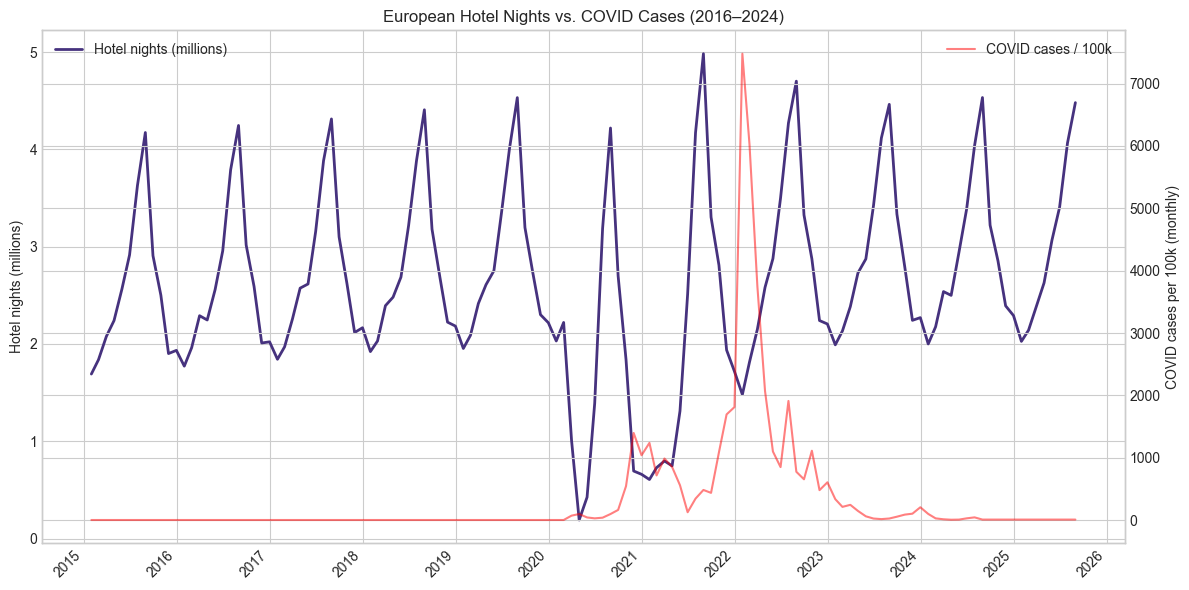

In [8]:
# %% -----------------------------------------------
# STEP 5.2 — EU-LEVEL TRENDS
# -----------------------------------------------

agg = (
    df_clean.groupby("month")[["nights_spent", "gdp", "unemployment_rate", "covid_cases"]]
    .mean()
    .reset_index()
)

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(agg["month"], agg["nights_spent"]/1e6, label="Hotel nights (millions)", linewidth=2)
ax1.set_ylabel("Hotel nights (millions)")
ax1.legend(loc="upper left")

# Twin y-axis for COVID cases
ax2 = ax1.twinx()
ax2.plot(agg["month"], agg["covid_cases"], color="red", alpha=0.5, label="COVID cases / 100k")
ax2.set_ylabel("COVID cases per 100k (monthly)")
ax2.legend(loc="upper right")

# Format x-axis to show one tick per year
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

plt.title("European Hotel Nights vs. COVID Cases (2016–2024)")
plt.tight_layout()
plt.show()

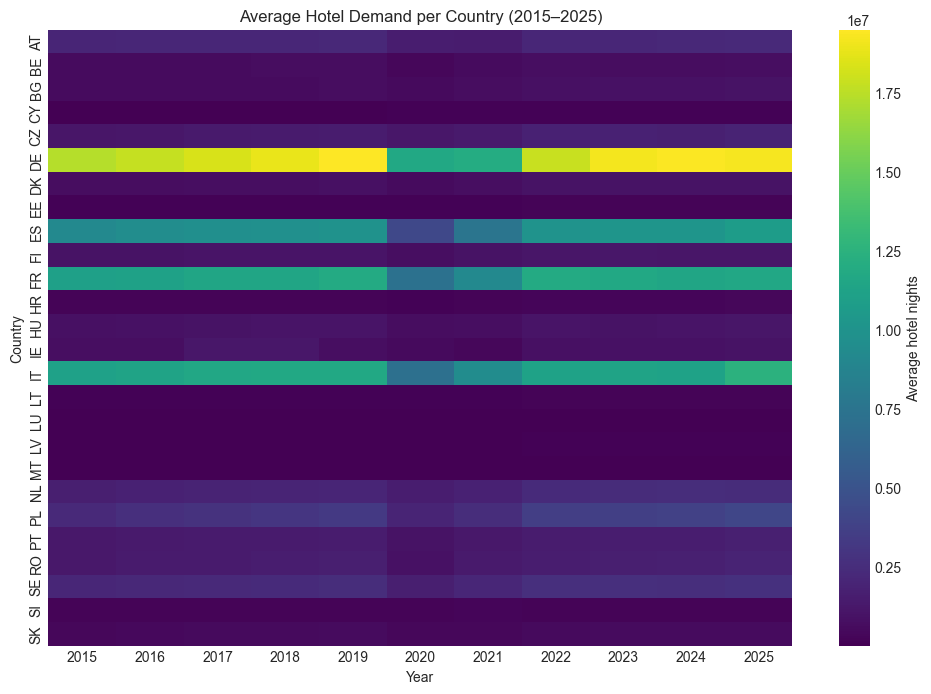

In [9]:
# %% -----------------------------------------------
# STEP 5.3 — COUNTRY-LEVEL RECOVERY
# -----------------------------------------------

pivot = df_clean.pivot_table(
    index="region", columns="year", values="nights_spent", aggfunc="mean"
)
plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="viridis", cbar_kws={'label': 'Average hotel nights'})
plt.title("Average Hotel Demand per Country (2015–2025)")
plt.xlabel("Year")
plt.ylabel("Country")
plt.show()

[INFO] Plotting distributions for 9 numeric indicators.


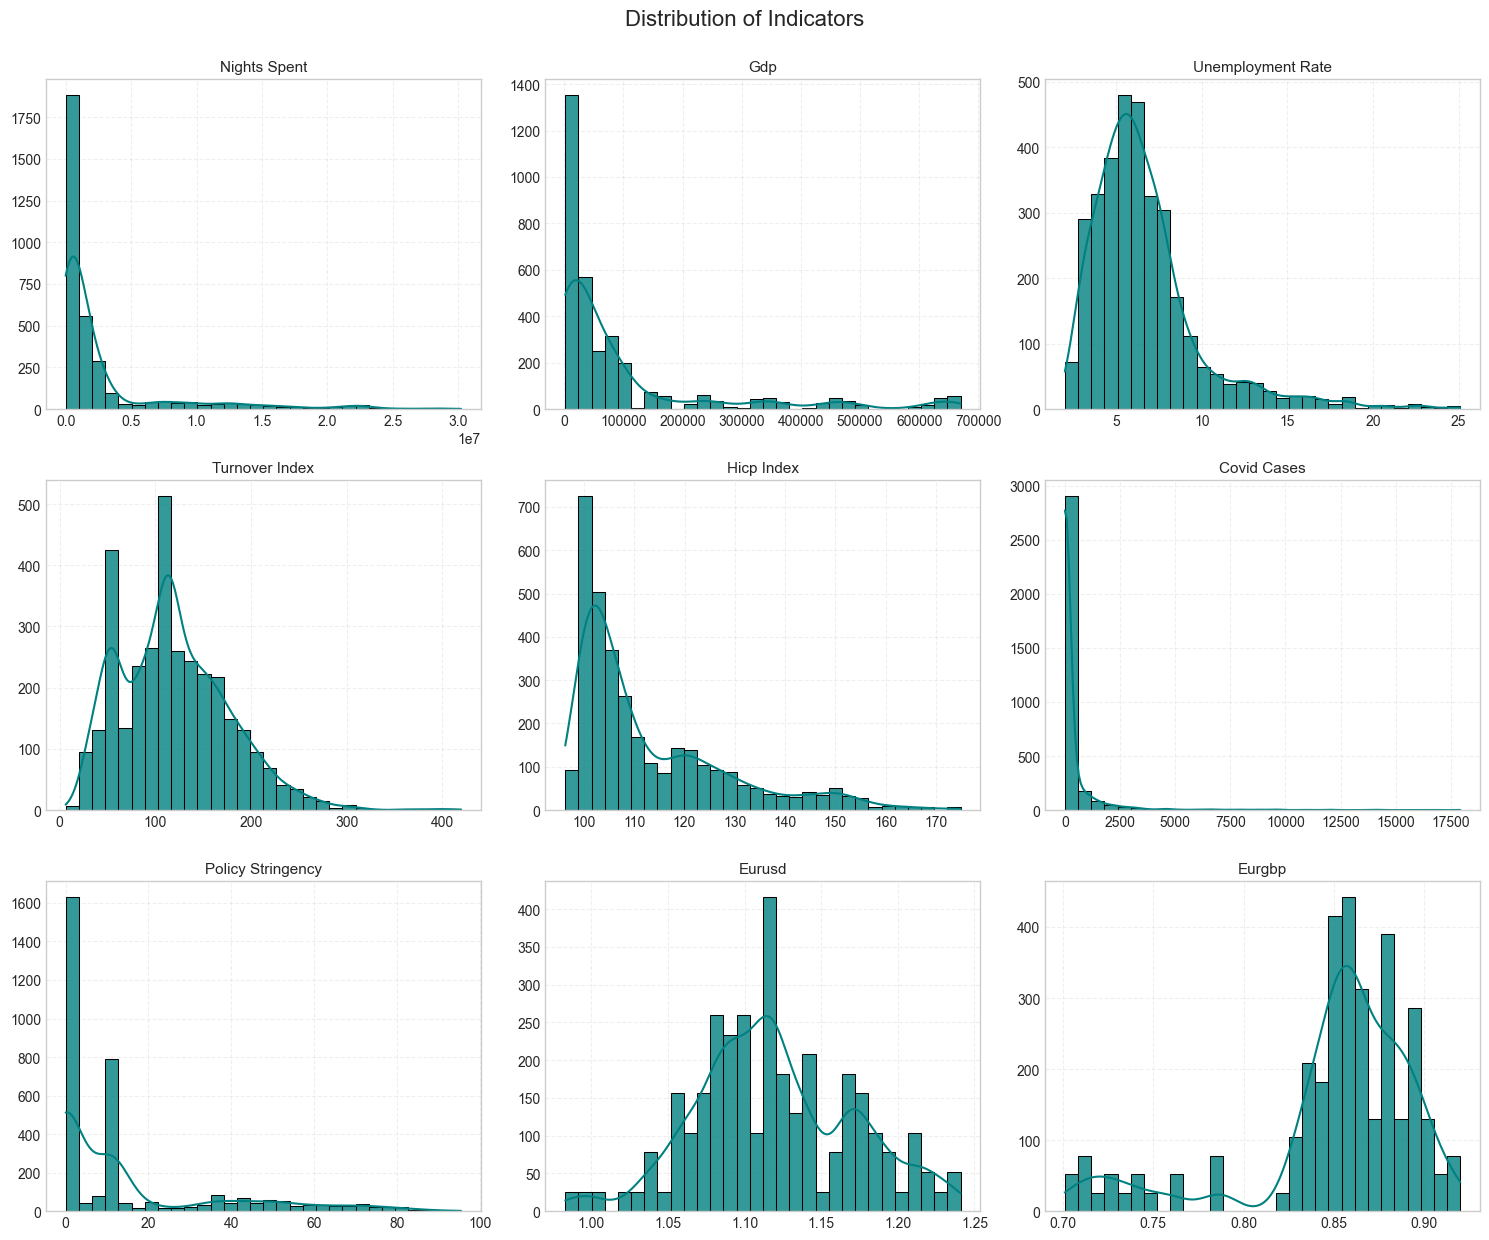

In [10]:
# %% -----------------------------------------------
# STEP 5.4 — INDICATOR DISTRIBUTIONS
# -----------------------------------------------

# --- Define numeric columns of interest ---
numeric_cols_all = [
    "nights_spent", "gdp", "unemployment_rate",
    "turnover_index", "hicp_index",
    "covid_cases", "policy_stringency",
    "eurusd", "eurgbp"
]

# --- Filter to columns present and valid ---
numeric_cols_all = [c for c in numeric_cols_all if c in df_clean.columns and df_clean[c].nunique() > 3]
print(f"[INFO] Plotting distributions for {len(numeric_cols_all)} numeric indicators.")

# --- Grid layout (3x3 since we have 9 plots) ---
n_cols = 3
n_rows = math.ceil(len(numeric_cols_all) / n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 4))

# --- Plot histograms ---
for i, col in enumerate(numeric_cols_all, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(
        x=df_clean[col].dropna(),
        kde=True,
        bins=30,
        color="teal",
        alpha=0.8,
    )
    plt.title(col.replace("_", " ").title(), fontsize=11)
    plt.xlabel("")
    plt.ylabel("")
    plt.grid(alpha=0.3, linestyle="--")

plt.tight_layout()
plt.suptitle("Distribution of Indicators", fontsize=16, y=1.03)
plt.show()

# Optional: reuse this list for correlation analysis
numeric_cols_corr = numeric_cols_all

[INFO] Using 9 numeric variables for correlation analysis: ['nights_spent', 'gdp', 'unemployment_rate', 'turnover_index', 'hicp_index', 'covid_cases', 'policy_stringency', 'eurusd', 'eurgbp']
[INFO] Correlation comparison heatmap saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/figures/correlation_heatmap_within_vs_raw.png


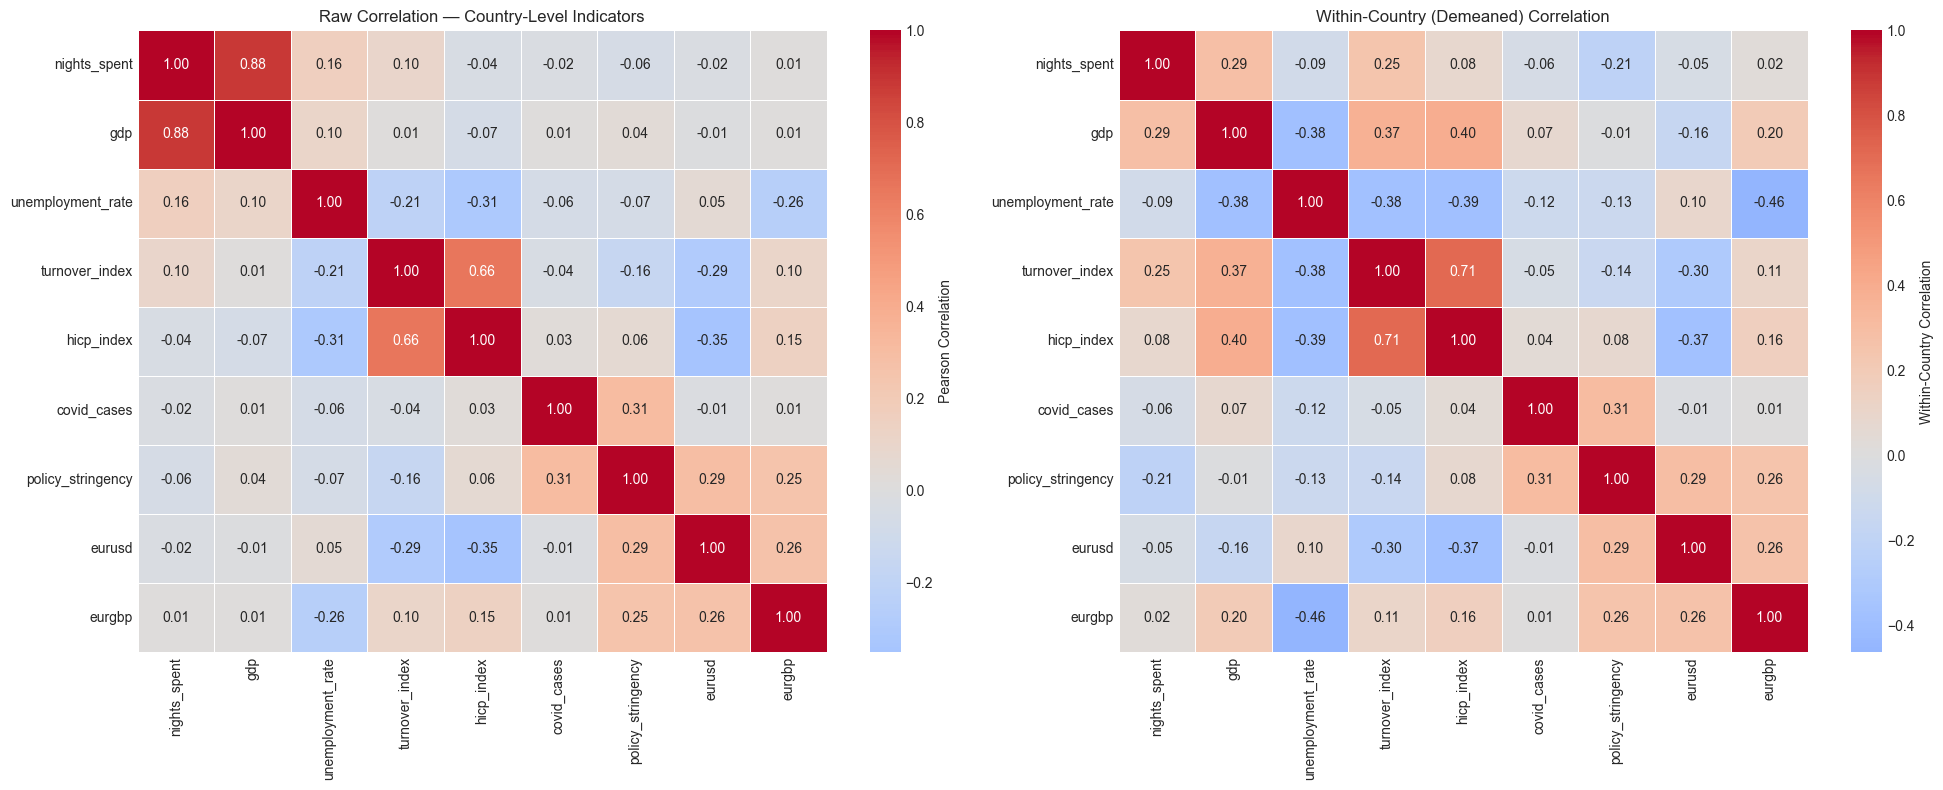

[INFO] Top within-country correlated indicators with nights spent:


,Within-Country Corr. with Nights Spent
nights_spent,1.000
gdp,0.288
turnover_index,0.249
hicp_index,0.083
eurgbp,0.024
eurusd,-0.050
covid_cases,-0.060
unemployment_rate,-0.087
policy_stringency,-0.210


[INFO] Correlation matrices exported → FIGURES directory


In [11]:
# %% -----------------------------------------------
# STEP 5.5 — CORRELATIONS AND FEATURE RELATIONSHIPS
# -----------------------------------------------

# --- Define numeric columns of interest ---
numeric_cols = [
    "nights_spent", "gdp", "unemployment_rate",
    "turnover_index", "hicp_index",
    "covid_cases", "policy_stringency",
    "eurusd", "eurgbp"
]
corr_cols = [c for c in numeric_cols if c in df_clean.columns]
print(f"[INFO] Using {len(corr_cols)} numeric variables for correlation analysis: {corr_cols}")

# --- Compute Pearson correlation (raw) ---
corr_raw = df_clean[corr_cols].corr(method="pearson")

# --- Compute within-country (demeaned) correlation ---
df_demeaned = df_clean.copy()
for col in corr_cols:
    df_demeaned[col] = df_clean.groupby("region")[col].transform(lambda x: x - x.mean())
corr_within = df_demeaned[corr_cols].corr(method="pearson")

# --- Optional: Spearman (rank-based) correlation ---
corr_spearman = df_clean[corr_cols].corr(method="spearman")

# --- Visualization: side-by-side heatmaps ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(
    corr_raw, cmap="coolwarm", center=0, annot=True, fmt=".2f",
    cbar_kws={"label": "Pearson Correlation"}, linewidths=0.5, ax=axes[0]
)
axes[0].set_title("Raw Correlation — Country-Level Indicators")

sns.heatmap(
    corr_within, cmap="coolwarm", center=0, annot=True, fmt=".2f",
    cbar_kws={"label": "Within-Country Correlation"}, linewidths=0.5, ax=axes[1]
)
axes[1].set_title("Within-Country (Demeaned) Correlation")

plt.tight_layout()

# --- Save both heatmaps ---
save_path = FIGURES / "correlation_heatmap_within_vs_raw.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"[INFO] Correlation comparison heatmap saved → {save_path.resolve()}")

plt.show()

# --- Identify top correlated indicators with hotel nights ---
top_corr = (
    corr_within["nights_spent"]
    .sort_values(ascending=False)
    .to_frame("Within-Country Corr. with Nights Spent")
    .round(3)
)
print("[INFO] Top within-country correlated indicators with nights spent:")
display(top_corr)

# --- Export correlation matrices ---
corr_raw.to_csv(REPORTS / "corr_raw.csv")
corr_within.to_csv(REPORTS / "corr_within_country.csv")
corr_spearman.to_csv(REPORTS / "corr_spearman.csv")
print("[INFO] Correlation matrices exported → FIGURES directory")

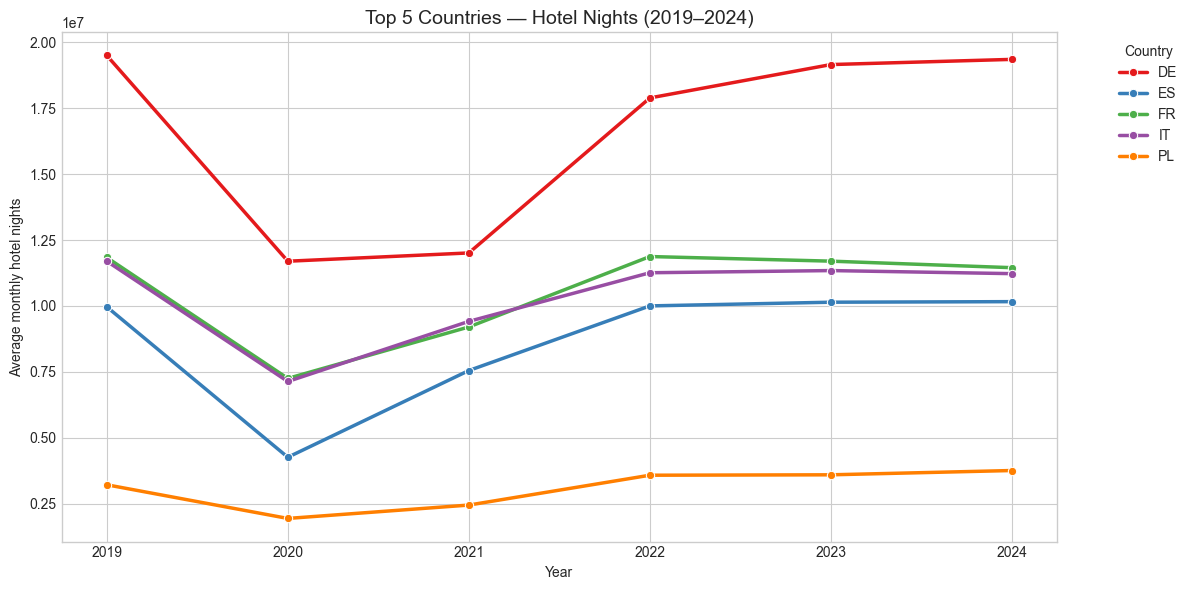

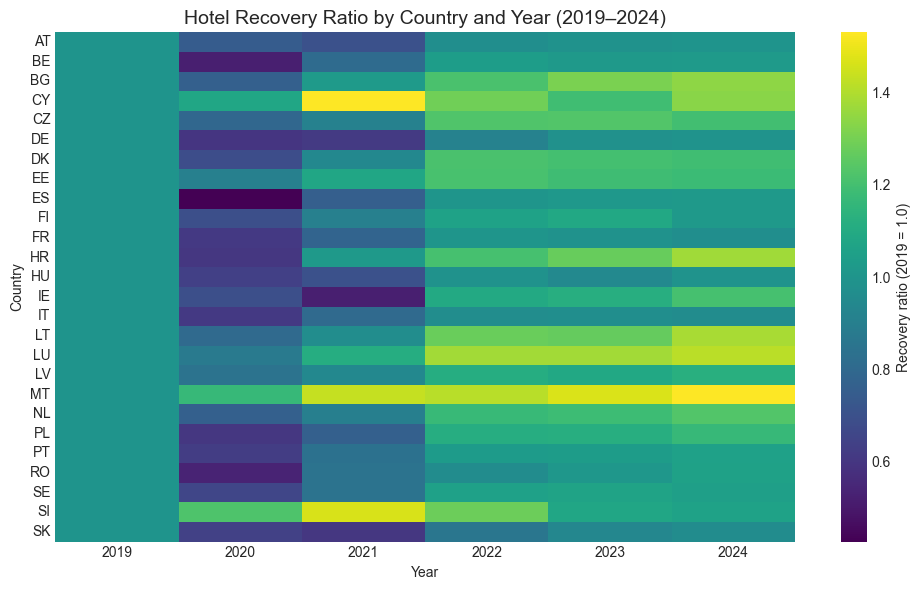

In [12]:
# %% -----------------------------------------------
# STEP 5.6 — RECOVERY PATTERNS (2019 - 2024)
# -----------------------------------------------

# Aggregate data by country (region) and year
recovery = (
    df_clean[df_clean["year"].between(2019, 2024)]
    .groupby(["region", "year"])["nights_spent"]
    .mean()
    .reset_index()
)

# Pivot → countries × years
recovery_pivot = recovery.pivot(index="region", columns="year", values="nights_spent")

# Normalize relative to 2019 baseline (Recovery ratio)
recovery_pivot = recovery_pivot.div(recovery_pivot[2019], axis=0)

# Fill any missing years (forward and backward)
recovery_pivot = recovery_pivot.ffill(axis=1).bfill(axis=1)

# --- Visualization 1: Country-level lines (Top 5 countries) ---
# Identify top 5 countries by mean hotel nights
top_regions = (
    recovery.groupby("region")["nights_spent"]
    .mean()
    .nlargest(5)
    .index
)

# Filter dataset
subset = recovery[recovery["region"].isin(top_regions)]

sns.set_palette("Set1")

# Plot
plt.figure(figsize=(12,6))
ax = sns.lineplot(
    data=subset,
    x="year", y="nights_spent", hue="region",
    estimator=None, linewidth=2.5, marker="o"
)
plt.title("Top 5 Countries — Hotel Nights (2019–2024)", fontsize=14)
plt.ylabel("Average monthly hotel nights")
plt.xlabel("Year")
ax.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title="Country",
    frameon=False,
    ncol=1
)
plt.tight_layout()
plt.show()

# --- Visualization 2: Recovery ratio heatmap ---
plt.figure(figsize=(10,6))
sns.heatmap(
    recovery_pivot,
    cmap="viridis",
    cbar_kws={'label': 'Recovery ratio (2019 = 1.0)'}
)
plt.title("Hotel Recovery Ratio by Country and Year (2019–2024)", fontsize=14)
plt.ylabel("Country")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

### 6. Save Clean Dataset and EDA Summary

In [13]:
# %% -----------------------------------------------
# STEP 6 — SAVE CLEAN DATASET AND EDA SUMMARY
# Purpose: Export harmonized dataset for modeling and documentation
# Outputs: data/processed/hotel_panel_clean.csv, outputs/reports/eda_summary.csv
# -----------------------------------------------

summary = {
    "total_countries": df_clean["region"].nunique(),
    "time_range": (df_clean["month"].min().strftime("%Y-%m"), df_clean["month"].max().strftime("%Y-%m")),
    "missing_share": df_clean.isna().mean().round(4).to_dict(),
    "avg_hotel_nights": round(df_clean["nights_spent"].mean(), 0),
    "min_year": df_clean["year"].min(),
    "max_year": df_clean["year"].max(),
}

summary_df = pd.DataFrame.from_dict(summary, orient="index", columns=["value"])
display(summary_df)

# Save summary
SUMMARY_PATH = REPORTS / "eda_summary.csv"
summary_df.to_csv(SUMMARY_PATH)
print(f"💾 Summary exported → {SUMMARY_PATH.resolve()}")

# Save clean dataset
CLEAN_PATH = DATA_PROCESSED / "hotel_panel_clean.csv"
df_clean.to_csv(CLEAN_PATH, index=False)
print(f"💾 Clean dataset saved successfully → {CLEAN_PATH.resolve()}")

# Verify saved files
for file_path in [SUMMARY_PATH, CLEAN_PATH]:
    if file_path.exists():
        print(f"✅ Verified: {file_path.name} ({file_path.stat().st_size / 1024:.1f} KB)")

,value
total_countries,26
time_range,"(2015-01, 2025-08)"
missing_share,"{'region': 0.0, 'month': 0.0, 'year': 0.0, 'ni..."
avg_hotel_nights,2624694.0
min_year,2015
max_year,2025


💾 Summary exported → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/reports/eda_summary.csv
💾 Clean dataset saved successfully → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/data/processed/hotel_panel_clean.csv
✅ Verified: eda_summary.csv (0.4 KB)
✅ Verified: hotel_panel_clean.csv (398.2 KB)


### 7. Insights and Next Steps

#### 🧾 Summary

This notebook successfully:
1. Consolidated monthly hotel nights and macroeconomic indicators for 26 EU countries (2015–2025).  
2. Conducted descriptive checks on missing values, temporal coverage, and summary statistics.  
3. Produced a harmonized and consistent dataset ready for modeling and feature engineering.

**Output:**  
📁 `../data/processed/hotel_panel_clean.csv`

**Next Steps → Notebook 2:**  
Proceed to feature engineering and baseline forecasting to model and explain European hotel demand recovery dynamics.